# Contents <a id='back'></a>

* [Introduction](#intro)
* [Step 1. Download data and prepare it for analysis](#data_review)
    * [Create library](#data_review_library)
    * [Load the data](#data_review_load)
    * [Fixing the data](#data_review_fix)
* [Step 2. Data analysis](#data_preprocessing)
    * [2.1 Proportion of various types of business](#analysis_1)
    * [2.2 Proportion of franchise-based and non-franchise businesses](#analysis_2)
    * [2.3 Business which is usually a franchise-based business](#analysis_3)
    * [2.4 Which are the characteristics of this type of franchise-based business](#analysis_4)
    * [2.5 The average number of seats for each type of business](#analysis_5)
    * [2.6 Move the address column to a separate column](#analysis_6)
    * [2.7 A chart showing the top ten street names](#analysis_7)
    * [2.8 Number of streets that have only one business](#analysis_8)
    * [2.9 The distribution of seat number](#analysis_9)
    * [2.10 General conclusion](#conclusion)
* [Step 3. Prepare the presentation](#presentation)
* [Findings](#end)

# Project Introduction

Every time we do an analysis, we need to formulate several testing and test analyzes that we need to test further. Sometimes, the tests we do lead us to accept the hypothesis, other times we also need to reject it. To make the right decisions in business, we must understand whether the assumptions we make are correct or not.

In this project as an analyst in this startup that sells food products we need to find out the behavior of application users from that company.

## Purpose:
1. Figure out which font will give the best results
2. find out how many users actually made it to the purchase stage
3. Find out how many users were stuck in the previous stages and at what stage exactly does this happen


## Steps
As for the data that we will retrieve and analyze stored in a file `/datasets/logs_exp_us.csv`.
There are several steps of the analysis this time, namely:
1. Download data and prepare it for analysis
2. Analyze data
3. Study the results of your experiment

[Back to Contents](#back)

# Step 1. Download data and prepare it for analysis

## Create library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import math
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

## Load the data

In [2]:
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


As can be seen, everything is great and there is no missing value found. As shown, we have all three experiments 246, 247 and 248.

## Rename the columns

In [6]:
data.rename(columns = {
    'EventName' : 'event',
    'DeviceIDHash' : 'user',
    'EventTimestamp' : 'timestamp',
    'ExpId' : 'exp_id',
}, inplace=True)
data.head()

,event,user,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Added date and time fields and a separate column for dates

In [7]:
data['date_time'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['date_time'].dt.floor('1D')
data.head()

,event,user,timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


# Step 2. Study and check the data

## How many events are in the logs?

In [8]:
events = len(data)
print(f'{events} events')

244126 events


## How many users are in the logs?

In [9]:
users = len(data['user'].unique())
print(f'{users} users')

7551 users


## What is the average number of events per user?

In [10]:
events_per_user = events / users
print(f'{events_per_user} events_per_user')

32.33028737915508 events_per_user


it clearly can be seen from the results that:
1. the total events in the logs are 244126 events
2. the total users in the logs are 7551 users
3. the average number of events per user are 32.33028737915508 events/user

## What time period does the data cover? Find the maximum and minimum dates. Construct a histogram based on the date and time. Can you ensure that the data you have is complete for all periods? Past events may appear in the logs of some users for technical reasons, and this can mess up the overall data distribution. Find the moment when the data starts to feel complete and ignore the old data. Which period does the data you have actually represent?

In [11]:
print(data['date_time'].min(), data['date_time'].max())

2019-07-25 04:43:36 2019-08-07 21:15:17


<AxesSubplot:>

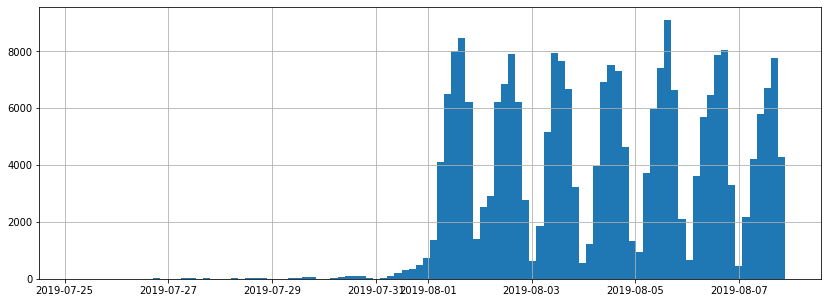

In [12]:
register_matplotlib_converters()
data['date_time'].hist(bins= 100, figsize=(14, 5))

<AxesSubplot:xlabel='date'>

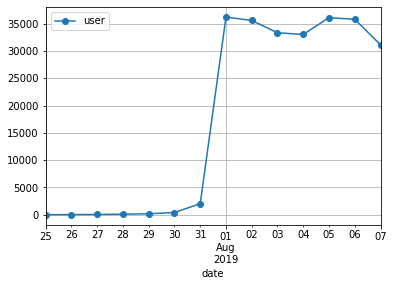

In [13]:
data.pivot_table(index= 'date', values='user', aggfunc= 'count').plot(style='o-', grid=True)

so now we can see or search for the earliest (25 july) and latest (7 august) dates.
However if looked at the histogram or plot, which is about 3 weeks apart. It can be seen that, before August 1, the amount of data is still relatively small. So, we can ignore data that appears before August 1.

In [14]:
data.query('date_time > "2019-07-31 21:00"', inplace=True)
data.head()

,event,user,timestamp,exp_id,date_time,date
1990,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31
1991,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31
1992,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31
1993,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31
1994,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31


<AxesSubplot:>

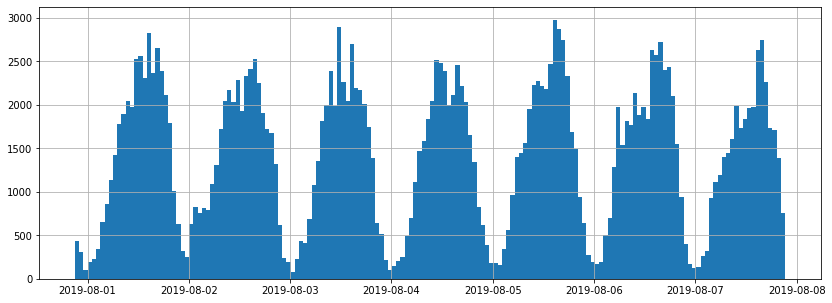

In [15]:
data['date_time'].hist(bins=7*24, figsize=(14, 5))

Now we have a week data from 2019-08-01 to 2019-08-07 (with three hour shifts) it's pretty much impossible to notice such a small change, so we doubt that we should focus on it.

## Did you lose a lot of events and users when you got rid of old data?

In [16]:
events = len(data)
users = len(data['user'].unique())
events_per_user = events / users
print(f'{events} events')
print(f'{users} users')
print(f'{events_per_user} events_per_user')

242136 events
7538 users
32.12204828867073 events_per_user


The result shows that we lost only 1%.

## Make sure you have users from all three experimental groups.

In [17]:
data['exp_id'].value_counts()

248    85039
246    79679
247    77418
Name: exp_id, dtype: int64

# Step 3. Study the funnel of events

## See what events are in the logs and how many times they occur. Sort those events by frequency

In [18]:
data.pivot_table(index='event', values='user', aggfunc='count').sort_values('user', ascending=False)

,user
event,
MainScreenAppear,117992
OffersScreenAppear,46548
CartScreenAppear,42406
PaymentScreenSuccessful,34146
Tutorial,1044


In the funnel, we need to know the order in which the funnels occur. And here we have 5 events, in the order of the main screen, off screen, chart screen, payment screen and the last one is the tutorial.

## Find the number of users who performed each action. Sort events by number of users. Calculate the proportion of users who performed an action at least once

In [19]:
user_per_event = (
    data
    .pivot_table(index='event', values='user', aggfunc=lambda x: x.nunique())
    .sort_values('user', ascending=False))
user_per_event

,user
event,
MainScreenAppear,7423
OffersScreenAppear,4597
CartScreenAppear,3736
PaymentScreenSuccessful,3540
Tutorial,843


In [20]:
user_per_event / len(data['user'].unique())

,user
event,
MainScreenAppear,0.984744
OffersScreenAppear,0.609843
CartScreenAppear,0.495622
PaymentScreenSuccessful,0.469621
Tutorial,0.111833


## In what order do you think the actions took place? Are they all part of one sequence?

We will fetch all the data in descending frequency except for the tutorial, as it is felt that there are quite a few of them.

## Use the event funnel to find the percentage of users who persist from one stage to the next. (For example, for the sequence of events A → B → C, calculate the ratio of users in stage B to the number of users in stage A, and the ratio of users in stage C to the number of users in stage B)

In [21]:
users_funnel = user_per_event[:-1]
users_funnel = (users_funnel / users_funnel.shift())[1:]
users_funnel

,user
event,
OffersScreenAppear,0.619291
CartScreenAppear,0.812704
PaymentScreenSuccessful,0.947537


From the data shown, it can known that how many successfully completed from the beginning to the end of the stage.

## At what stage did you lose a lot of users? 

The dramatical drop was seen in the first stage, the switch from MainScreenAppear to OffersScreenAppear. Might be the mechanism should be improved so that users switch to OffersScreenAppear.

## What percentage of users successfully complete all existing stages, from the first event to payment?

In [22]:
print('{} make it from the Main Screen to successful payment'
     .format((user_per_event.loc['PaymentScreenSuccessful'] / user_per_event.loc['MainScreenAppear'])['user']))

0.47689613363869054 make it from the Main Screen to successful payment


# Step 4. Study the results of your experiment

## How many users are there in each group?

In [23]:
users_per_group = data.pivot_table(index='exp_id', values='user', aggfunc=lambda x: x.nunique())['user']
users_per_group

exp_id
246    2484
247    2517
248    2537
Name: user, dtype: int64

## We have two control groups in A/A testing, where we check our mechanics and calculations. See if there is a statistically significant difference between samples 246 and 247

## Select the most popular events. In each control group, find the number of users who performed the action. Find the percentage. Check whether the differences between groups are statistically significant. Repeat this procedure for all other events (it will save time if you can create a custom function to perform this test). Can you confirm if the groups are properly split?

In [24]:
users_events_per_group = data.pivot_table(index='event', values='user', columns='exp_id', aggfunc=lambda x: x.nunique())
users_events_per_group

exp_id,246,247,248
event,,,
CartScreenAppear,1266,1239,1231
MainScreenAppear,2450,2479,2494
OffersScreenAppear,1542,1524,1531
PaymentScreenSuccessful,1200,1158,1182
Tutorial,278,284,281


In [25]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    #proportion of successes in the first ggroup:
    p1 = successes1 / trials1
    
    #proportion of successes in the second group:
    p2 = successes2 / trials2
    
    #proportion of successes in combined datasets:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    #the difference of proportions in datasets:
    difference = p1 - p2
    
    #calculating the statistic in standard deviation of standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    #setting standard normal distribution (mean=0, standard deviation=1)
    distr = stats.norm(0, 1)
    
    #calculating the statistic in standard deviations of standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('P_value: ', p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportion different")
        

In [26]:
check_hypothesis(users_events_per_group.loc['MainScreenAppear', 246],
                 users_events_per_group.loc['MainScreenAppear', 247],
                 users_per_group.loc[246],
                 users_per_group.loc[247],
                )

P_value:  0.6756217702005545
Failed to reject the null hypothesis: there is no reason to consider the proportion different


Here it can be seen, the most popular event is MainScreenAppear and by comparison between groups 246 and 247 the p_value is above 0.5 so we can reject the hypothesis. where:
1. H0 = the value of the proportions is the same (246 is equal to 247)
2. H1 = the value of the proportion is different (246 is not the same as 247).

In [27]:
def check_event_hypothesis(users_events_per_group, users_per_group, event, exp1, exp2):
    frac1 = users_events_per_group.loc[event, exp1] / users_per_group.loc[exp1]
    frac2 = users_events_per_group.loc[event, exp2] / users_per_group.loc[exp2]
    print(f'{frac1} with {event} event in group {exp1}')
    print(f'{frac2} with {event} event in group {exp2}')
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_per_group.loc[exp1],
                     users_per_group.loc[exp2],
                    )

In [28]:
for event in users_events_per_group.index:
    check_event_hypothesis(users_events_per_group, users_per_group, event, 246, 247)
    print()

0.5096618357487923 with CartScreenAppear event in group 246
0.4922526817640048 with CartScreenAppear event in group 247
P_value:  0.2182812140633792
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.9863123993558777 with MainScreenAppear event in group 246
0.9849026618990863 with MainScreenAppear event in group 247
P_value:  0.6756217702005545
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.6207729468599034 with OffersScreenAppear event in group 246
0.6054827175208581 with OffersScreenAppear event in group 247
P_value:  0.26698769175859516
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.4830917874396135 with PaymentScreenSuccessful event in group 246
0.4600715137067938 with PaymentScreenSuccessful event in group 247
P_value:  0.10298394982948822
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.11

we can state with a high degree of confidence that the results in the control group are the same. i.e. division into groups and calculations seem to be correct. And it showed all p_values are above 0.05 so we reject the null hypothesis. meaning that for the control group there was no statistically significant difference. and for each event there is no significant difference. which means that for each control group the proportion of people for each entry to the event is the same.

## Do the same for the group of users shown the latest font version. Compare the results with each control group for each event separately. Compare the results with the combined results for the control group. What conclusions can you draw from the experiment?

In [29]:
for event in users_events_per_group.index:
    check_event_hypothesis(users_events_per_group, users_per_group, event, 246, 248)
    print()

0.5096618357487923 with CartScreenAppear event in group 246
0.48521876231769806 with CartScreenAppear event in group 248
P_value:  0.08328412977507749
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.9863123993558777 with MainScreenAppear event in group 246
0.9830508474576272 with MainScreenAppear event in group 248
P_value:  0.34705881021236484
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.6207729468599034 with OffersScreenAppear event in group 246
0.6034686637761135 with OffersScreenAppear event in group 248
P_value:  0.20836205402738917
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.4830917874396135 with PaymentScreenSuccessful event in group 246
0.4659046117461569 with PaymentScreenSuccessful event in group 248
P_value:  0.22269358994682742
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0

Can not be seen a big difference here either. Even though the proportion of events per user has decreased, the difference remains statically insignificant. P_values are still above 0.05, meaning that in summery terms it can be said that in the test group there was no significant difference with the control group 246 the number of people who entered each screen was still the same, which meant that the difference in fonts did not really matter.

In [30]:
for event in users_events_per_group.index:
    check_event_hypothesis(users_events_per_group, users_per_group, event, 247, 248)
    print()

0.4922526817640048 with CartScreenAppear event in group 247
0.48521876231769806 with CartScreenAppear event in group 248
P_value:  0.6169517476996997
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.9849026618990863 with MainScreenAppear event in group 247
0.9830508474576272 with MainScreenAppear event in group 248
P_value:  0.6001661582453706
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.6054827175208581 with OffersScreenAppear event in group 247
0.6034686637761135 with OffersScreenAppear event in group 248
P_value:  0.8835956656016957
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.4600715137067938 with PaymentScreenSuccessful event in group 247
0.4659046117461569 with PaymentScreenSuccessful event in group 248
P_value:  0.6775413642906454
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.112

Even if we compare with the 247th group it is much worse than the previous 246th group. In this case, all events except the payout increase by a small amount, but all the differences are minuscule.

In [31]:
users_events_per_group_control = users_events_per_group.copy()
users_events_per_group_control.loc[:, 247] += users_events_per_group_control.loc[:, 246]
users_events_per_group_control.drop(columns= 246, inplace=True)
users_events_per_group_control

exp_id,247,248
event,,
CartScreenAppear,2505,1231
MainScreenAppear,4929,2494
OffersScreenAppear,3066,1531
PaymentScreenSuccessful,2358,1182
Tutorial,562,281


In [32]:
users_per_group_control = users_per_group.copy()
users_per_group_control.loc[247] += users_per_group_control.loc[246]
users_per_group_control.drop(246, inplace=True)
users_per_group_control

exp_id
247    5001
248    2537
Name: user, dtype: int64

In [33]:
for event in users_events_per_group.index:
    check_event_hypothesis(users_events_per_group_control, users_per_group_control, event, 247, 248)
    print()

0.5008998200359928 with CartScreenAppear event in group 247
0.48521876231769806 with CartScreenAppear event in group 248
P_value:  0.19819340844527744
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.9856028794241152 with MainScreenAppear event in group 247
0.9830508474576272 with MainScreenAppear event in group 248
P_value:  0.39298914928006035
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.6130773845230953 with OffersScreenAppear event in group 247
0.6034686637761135 with OffersScreenAppear event in group 248
P_value:  0.418998284007599
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.471505698860228 with PaymentScreenSuccessful event in group 247
0.4659046117461569 with PaymentScreenSuccessful event in group 248
P_value:  0.6452057673098244
Failed to reject the null hypothesis: there is no reason to consider the proportion different

0.112

As can be seen, the difference is not significant enough. In essence, it can be said that there is no significant difference between the control group and the test group in terms of how many users enter each event or each screen.

## What level of significance did you set to test the statistical hypothesis mentioned above? Count how many statistical hypothesis tests you have done. With a statistical significance level of 0.1 - one in 10 results could be wrong. What level of significance should be set? If you want to change it, just rerun the previous step and check your conclusions.

While the significant value chosen is equal to 0.05. and 5 hypothetical tests between each group test. so even if we change the alpha value to 0.01 or 0.1, the p-value will not change. What will change later is whether our p-value will be greater or smaller than alpha, which will affect whether we reject/fail to reject H0. So it will be more difficult later to fail to reject h-0, if the alpha value becomes 0.1

